In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from utils.sersic_functions import sersic_profile, generate_random_pos
from utils.download_data.h2f_download_functions import get_galaxy_img



# all pasquet dataset
# 0.05% -> 982883
# 0.02% -> 610370
# 0.01% -> 527723
# 0.001% -> 501835

# only train split (301096)
# 0.02% -> 366458
# 0.05% -> 590461

# X_train_autolabeling_pasquet (correcto) 193 any, 0 all
# X_val_autolabeling_pasquet (correcto) 40 any, 0 all
# X_test_autolabeling_pasquet (correcto) 52 any, 0 all

# X_train_pasquet (mal) 201 any, 29 all
# X_val_pasquet (mal) 48 any, 11 all

In [14]:
# import argparse
# import sys
# import os
# import time
# import pandas as pd
# import wandb
# import gc
# from pathlib import Path
# from lightning.pytorch.loggers import WandbLogger
# from lightning.pytorch.callbacks import LearningRateMonitor, RichProgressBar, ModelCheckpoint
# from lightning.pytorch.strategies import DDPStrategy
# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# from prism.datamodule import *
# from prism.model import *
# from utils.plot_functions import obtain_predicted_ra_dec

import torch 

def obtain_inputs(dataset_path, channels):

    data = np.load(dataset_path)

    X = data["imgs"]

    all_channels = ["g", "r", "i", "z", "y"]
    selected_channels = list(channels)
    idx_channels = [all_channels.index(c) for c in selected_channels]

    if X.shape[2] > 1: # multi-channel
        X = torch.from_numpy(X[:, :, idx_channels, :, :])
    else:
        X = torch.from_numpy(X)


    mask = (X.sum((3,4))==0).any((1,2)) # Casos con bandas == 0

    #z = torch.from_numpy(data["z"])
    pos = torch.from_numpy(data["pos"])


    return X[~mask], pos[~mask]#, z[~mask]


In [15]:
X_test, pos_test  = obtain_inputs(dataset_path= "/home/acontreras/PRISM/data/SERSIC/test_delight_fixed.npz", channels="r")

In [16]:
X_test.shape

torch.Size([4777, 5, 1, 30, 30])

In [17]:
resultados = np.load("/home/acontreras/PRISM/resultados/baseline_delight_r/test_results.npz")

In [18]:
mean_preds = torch.tensor(resultados["mean_preds"])
original_target = torch.tensor(resultados["original_target"])

In [19]:
residual_dist_pix = torch.norm(mean_preds - original_target, dim=1) * 0.25   
host_dist_pix = torch.norm(original_target, dim=1) * 0.25
normalized_residual = residual_dist_pix/host_dist_pix

In [39]:
df_test = pd.read_csv("/home/acontreras/PRISM/data/SERSIC/df_test_delight_fixed.csv", dtype={"sdss_objid": "Int64"})

In [20]:
df_target = pd.read_csv("/home/acontreras/PRISM/data/SERSIC/df_test_delight_fixed_objid.csv", dtype={"sdss_objid": "Int64"})
df_preds = pd.read_csv("/home/acontreras/PRISM/resultados/baseline_delight_r/test_predictions_objid.csv", dtype={"sdss_objid": "Int64"})

In [21]:
preds = (df_preds['sdss_objid'] == df_target['sdss_objid'])
mask_false = preds.fillna(True) == False

In [24]:
idx_sorted = torch.argsort(residual_dist_pix[mask_false])

/tmp/ipykernel_65407/446248283.py:1: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  idx_sorted = torch.argsort(residual_dist_pix[mask_false])


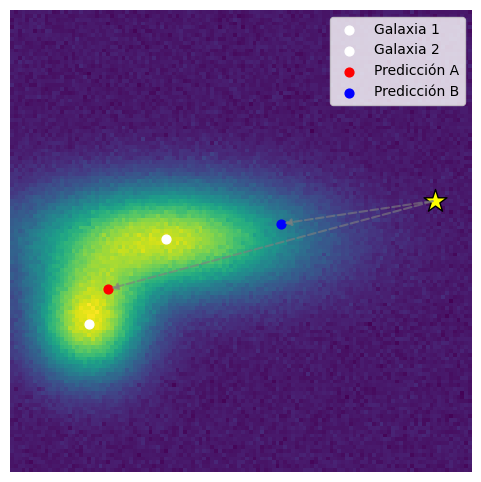

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.patches import FancyArrowPatch

# ----------------------------------------------------
# Galaxia sintética ELÍPTICA
# ----------------------------------------------------
def make_galaxy(img, center, intensity=1.0, size_x=10, size_y=7):
    h, w = img.shape
    y, x = np.indices((h, w))
    cy, cx = center
    R = np.sqrt(((x - cx)**2) / size_x**2 + ((y - cy)**2) / size_y**2)
    profile = intensity * np.exp(-(R**2) / 2)
    img += profile
    return img

# ----------------------------------------------------
# Cambiar resolución AQUÍ (más pequeño = menos resolución)
# ----------------------------------------------------
H = 120
W = 120

img = np.zeros((H, W))
center_image = np.array([H//2, W//2])

# ----------------------------------------------------
# Posiciones de galaxias (ajustadas a la resolución)
# ----------------------------------------------------
G1 = center_image + np.array([0, -20])       # galaxia grande
G2 = center_image + np.array([-22, -40])    # galaxia pequeña

# ----------------------------------------------------
# Dibujar galaxias (tamaños adaptados a la resolución)
# ----------------------------------------------------
img = make_galaxy(img, G1, intensity=5, size_x=25, size_y=10)  # grande elíptica
img = make_galaxy(img, G2, intensity=5, size_x=10, size_y=10)  # pequeña redonda

# Suavizado menor para imagen low-resolution
img = gaussian_filter(img, sigma=1)

# ----------------------------------------------------
# Generar puntos A y B
# ----------------------------------------------------
v = G1 - center_image
v = v / np.linalg.norm(v)

dist_A = 35
dist_B = 55

A = center_image + v * dist_A
B = center_image + v * dist_B

# ----------------------------------------------------
# Plot (manteniendo píxeles grandes)
# ----------------------------------------------------

noise_level = 0.1   # ajusta este valor (0.05 suave, 0.2 fuerte)
noise = np.random.normal(0, noise_level, img.shape)
img_noisy = img + noise

plt.figure(figsize=(6,6))
plt.imshow(img_noisy, cmap="viridis", origin="lower", interpolation="nearest")  # ← pixelado
plt.scatter([G1[1]], [G1[0]], c="white", s=40, label="Galaxia 1")
plt.scatter([G2[1]], [G2[0]], c="white", s=40, label="Galaxia 2")
plt.scatter(25, 47, c="red", s=40, label="Predicción A")
plt.scatter(70, 64, c="blue", s=40, label="Predicción B")
plt.scatter(110, 70,
                marker='*',         
                color='yellow',     
                s=300,              
                edgecolor='black') 

arrow1 = FancyArrowPatch(
    posA=(110, 70),     # inicio
    posB=(25, 47),      # final
    arrowstyle="-|>",   # flecha clásica
    mutation_scale=10,  # tamaño de la cabeza
    color="grey",
    alpha=0.6,          # ← transparencia
    linestyle="--",     # ← punteado
    linewidth=1.5
)

arrow2 = FancyArrowPatch(
    posA=(110, 70),     # inicio
    posB=(70, 64),      # final
    arrowstyle="-|>",   # flecha clásica
    mutation_scale=10,  # tamaño de la cabeza
    color="grey",
    alpha=0.6,          # ← transparencia
    linestyle="--",     # ← punteado
    linewidth=1.5
)

plt.gca().add_patch(arrow1)
plt.gca().add_patch(arrow2)

plt.legend()
plt.axis("off")
plt.show()


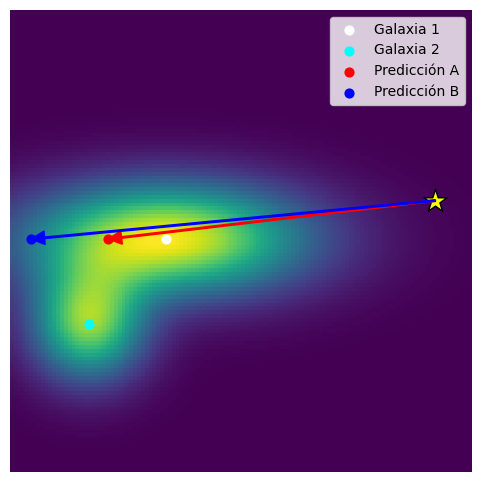

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# ----------------------------------------------------
# Galaxia sintética ELÍPTICA
# ----------------------------------------------------
def make_galaxy(img, center, intensity=1.0, size_x=10, size_y=7):
    h, w = img.shape
    y, x = np.indices((h, w))
    cy, cx = center
    R = np.sqrt(((x - cx)**2) / size_x**2 + ((y - cy)**2) / size_y**2)
    profile = intensity * np.exp(-(R**2) / 2)
    img += profile
    return img

# ----------------------------------------------------
# Cambiar resolución AQUÍ (más pequeño = menos resolución)
# ----------------------------------------------------
H = 120
W = 120

img = np.zeros((H, W))
center_image = np.array([H//2, W//2])

# ----------------------------------------------------
# Posiciones de galaxias (ajustadas a la resolución)
# ----------------------------------------------------
G1 = center_image + np.array([0, -20])       # galaxia grande
G2 = center_image + np.array([-22, -40])    # galaxia pequeña

# ----------------------------------------------------
# Dibujar galaxias (tamaños adaptados a la resolución)
# ----------------------------------------------------
img = make_galaxy(img, G1, intensity=1.6, size_x=25, size_y=10)  # grande elíptica
img = make_galaxy(img, G2, intensity=1.3, size_x=10, size_y=10)  # pequeña redonda

# Suavizado menor para imagen low-resolution
img = gaussian_filter(img, sigma=1)

# ----------------------------------------------------
# Generar puntos A y B
# ----------------------------------------------------
v = G1 - center_image
v = v / np.linalg.norm(v)

dist_A = 35
dist_B = 55

A = center_image + v * dist_A
B = center_image + v * dist_B

# ----------------------------------------------------
# Coordenadas de la estrella (origen de las flechas)
# ----------------------------------------------------
estrella_x = 110
estrella_y = 70

# ----------------------------------------------------
# Plot (manteniendo píxeles grandes)
# ----------------------------------------------------
plt.figure(figsize=(6,6))
plt.imshow(img, cmap="viridis", origin="lower", interpolation="nearest")  # ← pixelado

plt.scatter([G1[1]], [G1[0]], c="white", s=40, label="Galaxia 1")
plt.scatter([G2[1]], [G2[0]], c="cyan", s=40, label="Galaxia 2")

# Predicciones (usando A y B calculados)
plt.scatter(A[1], A[0], c="red", s=40, label="Predicción A")
plt.scatter(B[1], B[0], c="blue", s=40, label="Predicción B")

# estrella decorativa (origen de flechas)
plt.scatter(estrella_x, estrella_y,
            marker='*',
            color='yellow',
            s=300,
            edgecolor='black')

# -----------------------
# FLECHAS desde la estrella hasta A y B
# -----------------------
# flecha hacia A
plt.arrow(
    estrella_x, estrella_y,
    A[1] - estrella_x,  # dx (x_final - x_start)
    A[0] - estrella_y,  # dy (y_final - y_start)
    color="red",
    width=0.4,
    head_width=3.5,
    head_length=3.5,
    length_includes_head=True
)

# flecha hacia B
plt.arrow(
    estrella_x, estrella_y,
    B[1] - estrella_x,  # dx
    B[0] - estrella_y,  # dy
    color="blue",
    width=0.4,
    head_width=3.5,
    head_length=3.5,
    length_includes_head=True
)

plt.legend()
plt.axis("off")
plt.show()


In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.wcs import WCS
import matplotlib.cm as cm
import re

from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

from matplotlib.cm import viridis, plasma, jet, ScalarMappable


from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy import units as u
from tqdm import tqdm
from joblib import Parallel, delayed
import time

In [30]:
def nearest_sdss_galaxy(ra, dec, radius_arcmin=0.5):
    pos = coords.SkyCoord(ra, dec, unit="deg")
    while True:
        try:
            result = SDSS.query_crossid(
                pos,
                radius=radius_arcmin * u.arcmin,
                #spectro=True,
                photoobj_fields=['objid'],
                #specobj_fields=['zWarning','targetType','survey','primtarget'],
                data_release=17,
                cache=False,
            )
            # --- Caso: coordenadas fuera del footprint (respuesta vacía, NO error HTTP) ---
            if result is None or len(result) == 0:
                return None   # ← devolver NaN/None inmediatamente

            # --- Filtro según tus condiciones ---
            # mask = (
            #     (result['zWarning'] == 0) &
            #     (result['targetType'] == 'SCIENCE') &
            #     (result['survey'] == 'sdss') &
            #     (result['primtarget'] >= 64)
            # )
            # result = result[mask]

            # Nada cumple las condiciones → también es un "no match"
            if len(result) == 0:
                return None

            # Si llegamos aquí: todo bien → retornar el más cercano
            return result[0], len(result)

        except Exception as e:
            #print(f"Error con RA={ra}, DEC={dec}: {e}")
            #SDSS.clear_cache()
            time.sleep(1)  
            continue

In [44]:
df_target[mask_false].iloc[idx_sorted].head()


,sdss_objid,matches
796,1237659153685479918,1.0
2918,1237665569830863077,1.0
3518,1237663782593888796,1.0
479,1237668680466630412,1.0
185,1237654653629235718,1.0


In [45]:
df_preds[mask_false].iloc[idx_sorted].head()

,sdss_objid,matches
796,1237659153685479919,1.0
2918,1237665569830863078,1.0
3518,1237663782593888795,1.0
479,1237668680466630367,1.0
185,1237654653629235720,1.0


In [43]:
df_test[mask_false].iloc[idx_sorted].head()

,oid,host_name,host_redshift,host_ra,host_dec,meanra,meandec,host_coords,sn_coords,xhost,...,ySerNuErr,ySerPhi,ySerPhiErr,ySerRa,ySerDec,ySerRaErr,ySerDecErr,ySerChisq,sn_ra,sn_dec
796,ZTF20abbpkpa,WISEA J165623.70+264845.9,0.033063,254.098750,26.812750,254.098073,26.813855,"<SkyCoord (ICRS): (ra, dec) in deg\n (254.0...","<SkyCoord (ICRS): (ra, dec) in deg\n (254.0...",231.193155,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.098073,26.813855
2918,ZTF21abczhfv,WISEA J163945.09+482833.4,NaN,249.938000,48.475860,249.939414,48.475770,"<SkyCoord (ICRS): (ra, dec) in deg\n (249.9...","<SkyCoord (ICRS): (ra, dec) in deg\n (249.9...",253.547459,...,-999.0,-22.5993,0.000586,249.937805,48.475872,0.000024,0.000022,4.15019,249.939414,48.475770
3518,ZTF21abxugzk,SDSS J010458.68-010324.0,0.494884,16.244498,-1.056690,16.243999,-1.056875,"<SkyCoord (ICRS): (ra, dec) in deg\n (16.24...","<SkyCoord (ICRS): (ra, dec) in deg\n (16.24...",232.244521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.243999,-1.056875
479,ZTF20aaspvan,WISEA J193724.39+361954.4,0.038567,294.351625,36.331778,294.350022,36.331147,"<SkyCoord (ICRS): (ra, dec) in deg\n (294.3...","<SkyCoord (ICRS): (ra, dec) in deg\n (294.3...",221.323466,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,294.350022,36.331147
185,ZTF19acxmpnz,SDSS J072300.17+263722.0,0.060000,110.750708,26.622778,110.752222,26.622947,"<SkyCoord (ICRS): (ra, dec) in deg\n (110.7...","<SkyCoord (ICRS): (ra, dec) in deg\n (110.7...",258.948324,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.752222,26.622947


In [ ]:
out = nearest_sdss_galaxy(ra, dec, radius_arcmin)

In [2]:
df = pd.read_csv("../data/SERSIC/df_train_delight.csv")
#df = pd.read_csv("../data/SERSIC/df_pasquet_sersic_01_percent.csv")
#df = pd.read_csv("../data/SERSIC/df_train_clean_2_percent.csv")

### EDA

In [ ]:
# Radio de las elipses de Sersic (3 veces el radio) en pixeles
# En este caso seleccionamos 210 pixeles de radio

print(df["rSerRadius"].max()*3/0.25)
print(df["rSerRadius"].median()*3/0.25)
print(df["rSerRadius"].mean()*3/0.25)
print(df["rSerRadius"].std()*3/0.25)

data = df["rSerRadius"] * 3 / 0.25

# Definir bines logarítmicos desde 1 a 1000 (puedes ajustar la cantidad de bines)
bins = np.logspace(np.log10(1), np.log10(1000), num=20)

plt.hist(data, bins=np.linspace(0,300,30), histtype="step", linewidth=1.5)


#plt.xscale("log")
plt.yscale("log")
plt.xlabel("Major Axis [pix]")
plt.ylabel("Frecuencia")
plt.show()

### Funciones

In [3]:
def plot_galaxy_and_sersic(df, idx, Ie=1.0, n=4):
    """
    Visualiza una galaxia con su perfil radial, su perfil de Sérsic y distribuciones de posiciones 
    aleatorias de supernovas simuladas.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame con parámetros de galaxias y supernovas. Debe contener 
        las columnas: 
        - 'host_ra', 'host_dec' (coordenadas en grados, usadas en `get_sdss_img`)
        - 'rSerRadius' (radio efectivo en arcsec)
        - 'rSerAb' (relación de ejes b/a)
        - 'rSerPhi' (ángulo de posición en grados)
        - 'dx', 'dy' (desplazamiento en píxeles de la supernova respecto al centro).
    idx : int
        Índice de la fila en el DataFrame correspondiente a la galaxia a visualizar.
    Ie : float, optional
        Intensidad central del perfil de Sérsic. Default es 1.0.
    n : int, optional
        Índice de Sérsic (concentración del perfil). Default es 4 (perfil de de Vaucouleurs).

    Returns
    -------
    sersic_img : np.ndarray
        Imagen 2D con el perfil de Sérsic generado para la galaxia.
    random_pos : np.ndarray
        Arreglo de forma (1000, 2) con posiciones aleatorias simuladas de supernovas 
        dentro del perfil de Sérsic, centradas en el núcleo de la galaxia.

    Notes
    -----
    - La primera figura muestra la galaxia real con el perfil elíptico y 
      la posición de la supernova observada.
    - La segunda figura muestra el perfil de Sérsic simulado.
    - La tercera figura muestra un mapa de calor con las posiciones simuladas 
      de la supernova en 1000 iteraciones.
    """
    row = df.iloc[idx]
    image_data = get_galaxy_img(df, idx, level=0, size=240) #Imagen de 240x240 con resolucion 0.25 arcsec/pix

    # Coordenadas del centro
    x_center, y_center = image_data.shape[0]//2 -1 , image_data.shape[1]//2 -1

    # Parámetros de Sérsic
    Re_arcsec = row["rSerRadius"]
    b_over_a = row["rSerAb"]
    theta_sersic = row["rSerPhi"]  # Usar el ángulo original
    pixel_scale = 0.25
    Re_pix = Re_arcsec / pixel_scale
    A_pix = Re_pix
    B_pix = A_pix * b_over_a

    # Generar perfil de Sérsic
    sersic_img = sersic_profile(
        image_shape=image_data.shape,
        x_center=x_center, y_center=y_center,
        Re_arcsec=Re_arcsec,
        b_over_a=b_over_a,
        theta_deg=theta_sersic,  
        pixel_scale=pixel_scale,
        Ie=Ie,
        n=n
    )

    # vemos las posiciones que tomo la supernova en 1000 iteraciones
    random_pos = []
    for _ in range(1):
        pos = generate_random_pos(sersic_radius = Re_arcsec, 
                                    sersic_ab = b_over_a, 
                                    sersic_phi = theta_sersic, 
                                    img_size = image_data.shape[0])
        random_pos.append(pos) 

    random_pos =  np.array(random_pos) + x_center
    x_iter = random_pos[:, 0]
    y_iter = random_pos[:, 1]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=300)

    dx, dy = row[["dx","dy"]].values

    x_star = x_center + dx
    y_star = y_center + dy

    # Imagen real con elipse
    ax1 = axes[0]

    # Posicion SN real
    ax1.scatter(x_star, y_star,
                marker='*',         
                color='yellow',     
                s=500,              
                edgecolor='black')  
    
    ax1.imshow(image_data, cmap='gray', origin="lower",
               vmin=np.percentile(image_data, 1),
               vmax=np.percentile(image_data, 99))
    

    for r in [3]:
        ellipse = Ellipse((x_center, y_center),
                        width=B_pix * 2 * r,
                        height=A_pix * 2 * r,
                        angle=theta_sersic+90,
                        edgecolor='red',
                        facecolor='none',
                        lw=1.5,
                        linestyle='--' if r < 3 else '-')
        ax1.add_patch(ellipse)

    ax1.set_title("Galaxia con perfil elíptico")
    ax1.axis('off')

    # Mostrar perfil de Sérsic
    ax2 = axes[1]
    im = ax2.imshow(sersic_img, cmap='viridis', vmin=0, vmax=150, origin="lower")

    # Posciones SN arbitrarias
    for r in [3]:
        ellipse = Ellipse((x_center, y_center),
                        width=B_pix * 2 * r,
                        height=A_pix * 2 * r,
                        angle=theta_sersic+90,
                        edgecolor='red',
                        facecolor='none',
                        lw=1.5,
                        linestyle='--' if r < 3 else '-')
        ax2.add_patch(ellipse)

    ax2.set_title("Perfil de Sérsic (n=4)")
    ax2.axis('off')
    fig.colorbar(im, ax=ax2, label='Intensidad')

    ax3 = axes[2]
    hist, _, _ = np.histogram2d(x_iter, y_iter, bins=240, range=[[0, 240], [0, 240]])
    im3 = ax3.imshow(hist.T, cmap='viridis', interpolation='nearest', origin="lower", vmin=0, vmax=30)
    ax3.set_title('Posiciones supernova 10000 sampleos arbitrarios')
    ax3.axis('off')
    fig.colorbar(im3, ax=ax3, label='Frecuencia')


    plt.tight_layout()
    plt.show()

    return sersic_img, random_pos

### Plots

In [ ]:
https://alasky.cds.unistra.fr/hips-image-services/hips2fits
https://alaskybis.cds.unistra.fr/hips-image-services/hips2fits 

In [ ]:
# 203.5415734530934, 17.83389771938655

In [11]:
from astroquery.hips2fits import hips2fits
hips2fits.server = "https://alaskybis.cds.unistra.fr/hips-image-services/hips2fits"

In [12]:
for idx in range(100):
    _ = plot_galaxy_and_sersic(df = df, idx = idx) 

SSLError: HTTPSConnectionPool(host='alaskybis.cds.unistra.fr', port=443): Max retries exceeded with url: /hips-image-services/hips2fits?wcs=%7B%22WCSAXES%22%3A+2%2C+%22CRPIX1%22%3A+120.0%2C+%22CRPIX2%22%3A+120.0%2C+%22CDELT1%22%3A+-6.9444446125998e-05%2C+%22CDELT2%22%3A+6.9444446125999e-05%2C+%22CUNIT1%22%3A+%22deg%22%2C+%22CUNIT2%22%3A+%22deg%22%2C+%22CTYPE1%22%3A+%22RA---TAN%22%2C+%22CTYPE2%22%3A+%22DEC--TAN%22%2C+%22CRVAL1%22%3A+282.62508%2C+%22CRVAL2%22%3A+80.18558%2C+%22LONPOLE%22%3A+180.0%2C+%22LATPOLE%22%3A+80.18558%2C+%22MJDREF%22%3A+0.0%2C+%22RADESYS%22%3A+%22ICRS%22%2C+%22NAXIS1%22%3A+240%2C+%22NAXIS2%22%3A+240%7D&min_cut=0.5%25&max_cut=99.5%25&cmap=Greys_r&stretch=linear&hips=CDS%2FP%2FPanSTARRS%2FDR1%2Fr&format=fits (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1010)')))